# Classify Abnormal EEG using Information about Spikes and Frequency Power

### Authors: Alana Tillery and Patrick Myers

Imports

In [1]:
import json
from pathlib import Path
import collections
from collections import defaultdict
from collections import Counter
import glob
import mne
from mne_bids import get_entity_vals
import matplotlib as pml
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.core.common import flatten
import os
import random
from random import randint
import re
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.model_selection import(
    train_test_split,
    StratifiedShuffleSplit,
    cross_validate
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    f1_score,
    roc_curve,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    brier_score_loss,
    plot_precision_recall_curve,
    precision_recall_curve,
)
from sklearn.feature_selection import SelectKBest, chi2
import statsmodels.api as sm
from episcalp.spikes.run_spike_analysis import run_spike_analysis
from sample_code.study import generate_spike_feature

# 1.0 Set Up

## 1.1 Define hyperparameters for modeling/plotting

In [2]:
# Dict where keys are group names and values are the label assigned to that group
include_subject_groups = {
    'non-epilepsy': 0,
    'epilepsy-normal': 0,
    'epilepsy-abnormal': 1,
}
# List of subjects to exclude from analysis
exclude_subjects = None
# Features to use in the model
include_feature_groups = ['total_spike_rate', 'max_spike_rate', 'frontal_lobe_spike_rate', 'parietal_lobe_spike_rate', 'temporal_lobe_spike_rate', 'occipital_lobe_spike_rate']
extra_params = [None, None, {"lobe": "frontal"}, {"lobe": "parietal"}, {"lobe": "temporal"}, {"lobe": "occipital"}]
nfeats = len(include_feature_groups)
kfeats = 5

cross_val_splits = 10

bids_root = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/40Hz-30")
deriv_root = bids_root / "derivatives"

## 1.2 Read in the metadata sheet

In [3]:
# Read metadata excel spreadsheet into a dataframe
meta_fpath = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/JHU_scalp_clinical_datasheet_raw_local.xlsx")
meta_df = pd.read_excel(meta_fpath)

## 1.3 Read in data

In [4]:
subjects = get_entity_vals(bids_root, 'subject', ignore_subjects=exclude_subjects)
nsubs = len(subjects)
spikes_root = deriv_root / "spikes" / "monopolar"

# Put spike features into a dict with subject_id keys and spike dict as the values
subject_spike_map = dict()
for subject in subjects:
    subject_dir = spikes_root / f"sub-{subject}"
    json_fpath = list(subject_dir.glob("*.json"))[0]
    with open(json_fpath) as f:
        spike_data = json.load(f)
    subject_spike_map[subject] = spike_data


# 2.0 Feature Generation / Selection

## 2.1 Feature Generation - Spike Data

In [5]:
# Iterate over desired features, appending a column to our formatted X each time
formatted_X = np.zeros((nsubs, nfeats), np.float64)
for idx, (feature, extra_param) in enumerate(zip(include_feature_groups, extra_params)):
    unformatted_X, y, groups, subject_ids = generate_spike_feature(subject_spike_map, feature, include_subject_groups, extra_param)
    formatted_X[:, idx] = unformatted_X

### 2.1.1 Remove Outliers
We are defining outliers to be subjects in the epilepsy-abnormal group that had 0 detected spikes

In [6]:
include_inds = []
removed_pt_ids = []
try:
    spike_rate_index = include_feature_groups.index('total_spike_rate')
except ValueError as e:
    print('Cannot search for outliers', e)
    spike_rate_index = None
if spike_rate_index is not None:
    print('Searching for outliers')
    spike_rates = [x[spike_rate_index] for x in formatted_X]
    for idx, spike_rate in enumerate(spike_rates):
        group = groups[idx]
        if spike_rate == 0.0 and group == 2:
            print(f"removing outlier: {subject_ids[idx]}")
            removed_pt_ids.append(subject_ids[idx])
        else:
            include_inds.append(idx)
    formatted_X = formatted_X[include_inds, :]
    y = y[include_inds]
    groups = groups[include_inds]
    subject_ids = subject_ids[include_inds]

Searching for outliers
removing outlier: 203
removing outlier: 217
removing outlier: 222
removing outlier: 225


In [7]:
removed_pt_ids

['203', '217', '222', '225']

## 2.2 Feature Visualization

### 2.2.1 Total Spike Rate and Max Spike Rate

In [8]:
%matplotlib inline

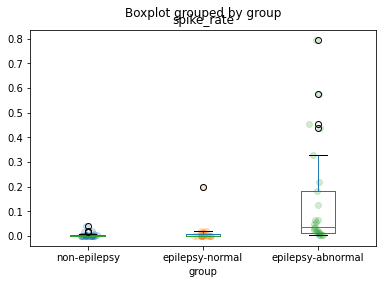

In [9]:
# Total spike Rate
total_spike_rate_idx = include_feature_groups.index('total_spike_rate')
total_spike_rates = [x[total_spike_rate_idx] for x in formatted_X]
spike_rate_df = pd.DataFrame()
spike_rate_df['spike_rate'] = total_spike_rates
spike_rate_df['group'] = groups

group_names = list(include_subject_groups.keys())
xticks = [i+1 for i, g in enumerate(group_names)]

fig, ax = plt.subplots()
bp = spike_rate_df.boxplot(column='spike_rate', by='group', grid=False, ax=ax)
for gdx, g in enumerate(group_names):
    spike_rates_group = [sr for idx, sr in enumerate(total_spike_rates) if groups[idx] == gdx]
    x = np.random.normal(gdx+1, 0.04, size=len(spike_rates_group))
    plt.scatter(x, spike_rates_group, alpha=0.2, label=g)

ax.set_xticks(xticks)
ax.set_xticklabels(group_names)

    
plt.show()


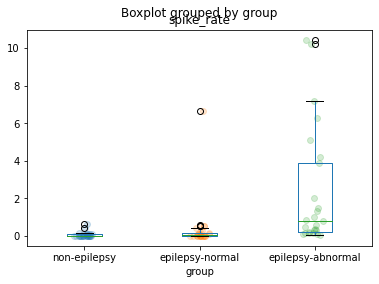

In [10]:
# Max spike Rate
max_spike_rate_idx = include_feature_groups.index('max_spike_rate')
max_spike_rates = [x[max_spike_rate_idx] for x in formatted_X]
spike_rate_df = pd.DataFrame()
spike_rate_df['spike_rate'] = max_spike_rates
spike_rate_df['group'] = groups

group_names = list(include_subject_groups.keys())
xticks = [i+1 for i, g in enumerate(group_names)]

fig, ax = plt.subplots()
bp = spike_rate_df.boxplot(column='spike_rate', by='group', grid=False, ax=ax)
for gdx, g in enumerate(group_names):
    spike_rates_group = [sr for idx, sr in enumerate(max_spike_rates) if groups[idx] == gdx]
    x = np.random.normal(gdx+1, 0.04, size=len(spike_rates_group))
    plt.scatter(x, spike_rates_group, alpha=0.2, label=g)

ax.set_xticks(xticks)
ax.set_xticklabels(group_names)

    
plt.show()


### 2.2.2 Spike Rate Per Channel

<ipython-input-11-46cc73940ec8>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ug].set_xticklabels(ch_names, rotation = 45, ha="right")
<ipython-input-11-46cc73940ec8>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ug].set_xticklabels(ch_names, rotation = 45, ha="right")
<ipython-input-11-46cc73940ec8>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ug].set_xticklabels(ch_names, rotation = 45, ha="right")


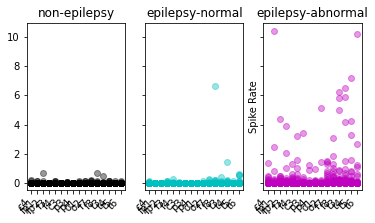

In [11]:
fig, axs = plt.subplots(1, 3, sharey=True)
spike_rate_df = pd.DataFrame()
spike_rate_df['group'] = groups
ch_names = list(subject_spike_map['001'].keys())
for ch in ch_names:
    ch_rates = []
    for sub, spike_dict in subject_spike_map.items():
        if sub not in removed_pt_ids:
            ch_rates.append(spike_dict.get(ch, 0.0))
    spike_rate_df[ch] = ch_rates
colors=['k', 'c', 'm']
unique_groups = np.unique(groups)
for ug in unique_groups:
    ch_df = spike_rate_df[spike_rate_df['group'] == ug]
    ch_df_melt = ch_df.melt(id_vars=['group'])
    axs[ug].scatter(x=ch_df_melt['variable'], y=ch_df_melt['value'], alpha=0.4, c=colors[ug])
    axs[ug].set_xticklabels(ch_names, rotation = 45, ha="right")
    axs[ug].set_title(list(include_subject_groups.keys())[ug])
    
plt.subplots_adjust(bottom=0.30)
plt.ylabel('Spike Rate')
plt.show()

### 2.2.3 Spike Rate Per Lobe

<ipython-input-12-ab4e75d29c95>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ug].set_xticklabels(lobe_names, rotation = 45, ha="right")
<ipython-input-12-ab4e75d29c95>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ug].set_xticklabels(lobe_names, rotation = 45, ha="right")
<ipython-input-12-ab4e75d29c95>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ug].set_xticklabels(lobe_names, rotation = 45, ha="right")


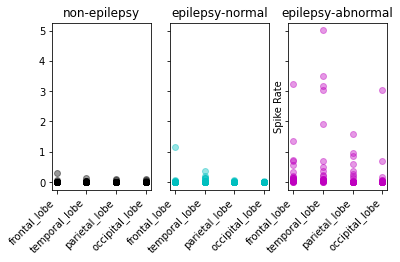

In [12]:
fig, axs = plt.subplots(1, 3, sharey=True)
spike_rate_df = pd.DataFrame()
spike_rate_df['group'] = groups
lobe_names = ['frontal_lobe', 'temporal_lobe', 'parietal_lobe', 'occipital_lobe']
for lobe in lobe_names:
    lobe_spike_rate_idx = include_feature_groups.index(f'{lobe}_spike_rate')
    lobe_spike_rates = [x[lobe_spike_rate_idx] for x in formatted_X]
    spike_rate_df[lobe] = lobe_spike_rates

colors=['k', 'c', 'm']
unique_groups = np.unique(groups)
for ug in unique_groups:
    lobe_df = spike_rate_df[spike_rate_df['group'] == ug]
    lobe_df_melt = lobe_df.melt(id_vars=['group'])
    axs[ug].scatter(x=lobe_df_melt['variable'], y=lobe_df_melt['value'], alpha=0.4, c=colors[ug])
    axs[ug].set_xticklabels(lobe_names, rotation = 45, ha="right")
    axs[ug].set_title(list(include_subject_groups.keys())[ug])
    
plt.subplots_adjust(bottom=0.30)
plt.ylabel('Spike Rate')
plt.show()

## 2.3 Feature Selection - Get K Best Features

In [13]:
# Select kfeats features and trim X to only include those features
if kfeats < nfeats:
    feature_selector = SelectKBest(chi2, k=kfeats)
    trimmed_X = feature_selector.fit_transform(formatted_X, y)
    feature_bool = feature_selector.get_support()
    feature_arr = np.array(include_feature_groups)
    included_feats = feature_arr[feature_bool]
else:
    trimmed_X = formatted_X.copy()
    included_feats = np.array(include_feature_groups)

# 3.0 Run the classification

## 3.1 Set up cross validation

In [14]:
sss = StratifiedShuffleSplit(n_splits=cross_val_splits, test_size=0.2, random_state=0)

## 3.2 Set up classifier(s)

In [15]:
clf = LogisticRegression()

## 3.3 Set up cross-val

In [16]:
def dummy_cv(train, test):
    yield train, test

## 3.4 Run Cross-val experiment

In [17]:
def combine_patient_predictions(
    y_trues, ypred_probs, subject_groups, pat_predictions=None, pat_true=None
):
    if pat_predictions is None or pat_true is None:
        pat_predictions = collections.defaultdict(list)
        pat_true = dict()
        
    # loop through things
    for ytrue, ypred_proba, subject in zip(y_trues, ypred_probs, subject_groups):
        pat_predictions[str(subject)].append(float(ypred_proba))
        
        if subject not in pat_true:
            pat_true[str(subject)] = ytrue
        else:
            if pat_true[str(subject)] != ytrue:
                raise RuntimeError("subjects should match...")
    return pat_predictions, pat_true

In [18]:
cv_scores = collections.defaultdict(list)
scoring_funcs = {
    "roc_auc": roc_auc_score,
    "accuracy": accuracy_score,
    "balanced_accuracy": balanced_accuracy_score,
    "average_precision": average_precision_score,
}
for train_inds, test_inds in sss.split(trimmed_X, y):
    cv_scores["train_inds"].append(list(train_inds))
    cv_scores["test_inds"].append(list(test_inds))
    cv = dummy_cv(train_inds, test_inds)

    scores = cross_validate(
        clf,
        trimmed_X,
        y,
        groups=groups,
        cv=cv,
        scoring=list(scoring_funcs.keys()),
        return_estimator=True,
        return_train_score=True,
    )
    
    # removing array like structure
    scores = {key: val[0] for key, val in scores.items()}
    estimator = scores.pop("estimator")

    coeff_ = list(estimator.coef_)
    intercept_ = estimator.intercept_
    coeff = list(intercept_.copy())
    [coeff.extend(c) for c in coeff_]

    X_test, y_test = np.array(trimmed_X)[test_inds, ...], np.array(y)[test_inds]
    groups_test = np.array(groups)[test_inds]
    subjects_test = subject_ids[test_inds]


    y_pred_prob = estimator.predict_proba(trimmed_X)[:, 1]
    y_pred = estimator.predict(trimmed_X)
    

    cv_scores["validate_ytrue"].append(list(y_test))
    cv_scores["validate_ypred_prob"].append(list(y_pred_prob))
    cv_scores["validate_ypred"].append(list(y_pred))
    cv_scores["validate_subject_groups"].append(list(groups_test))

    # store ROC curve metrics on the held-out test set
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob, pos_label=1)
    fnr, tnr, neg_thresholds = roc_curve(y, y_pred_prob, pos_label=0)
    cv_scores["validate_fpr"].append(list(fpr))
    cv_scores["validate_tpr"].append(list(tpr))
    cv_scores["validate_fnr"].append(list(fnr))
    cv_scores["validate_tnr"].append(list(tnr))
    cv_scores["validate_thresholds"].append(list(thresholds))
    cv_scores["coeff"].append(list(coeff))
    
    try:
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y, y_pred_prob, n_bins=10, strategy="quantile"
        )
    except Exception as e:
        try:
            print(e)
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y, y_pred_prob, n_bins=5, strategy="uniform"
            )
        except Exception as e:
            print(e)
            fraction_of_positives = [None]
            mean_predicted_value = [None]
    clf_brier_score = np.round(
        brier_score_loss(y, y_pred_prob, pos_label=np.array(y).max()), 2
    )

    print("Done analyzing calibration stats...")

    # store ingredients for a calibration curve
    cv_scores["validate_brier_score"].append(float(clf_brier_score))
    cv_scores["validate_fraction_pos"].append(list(fraction_of_positives))
    cv_scores["validate_mean_pred_value"].append(list(mean_predicted_value))

    pat_predictions, pat_true = combine_patient_predictions(
        y, y_pred_prob, subjects_test
    )
    cv_scores["validate_pat_predictions"].append(pat_predictions)
    cv_scores["validate_pat_true"].append(pat_true)

Done analyzing calibration stats...
Done analyzing calibration stats...
Done analyzing calibration stats...
Done analyzing calibration stats...
Done analyzing calibration stats...
Done analyzing calibration stats...
Done analyzing calibration stats...
Done analyzing calibration stats...
bins must be monotonically increasing or decreasing
Done analyzing calibration stats...
Done analyzing calibration stats...


# 4.0 Plot Results

## 4.1 Define Additional Plotting Functions

In [19]:
def average_roc(fpr, tpr):
    """Compute average ROC statistics."""
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)

    n_splits = len(fpr)
    print(f"Computing average ROC over {n_splits} CV splits")
    for i in range(n_splits):
        interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(mean_fpr, interp_tpr))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    print(f"Found mean tpr: {mean_tpr}")
    std_tpr = np.std(tprs, axis=0)
    return mean_fpr, tprs, aucs

In [20]:
from scipy.spatial.distance import cdist

# get line between optimum and clinical op point
def create_line(x1, x2, y1, y2, n_points=200):
    slope = (y2 - y1) / (x2 - x1)

    xs = np.linspace(x1, x2, n_points)
    ys = np.linspace(y1, y2, n_points)

    return xs, ys


def find_intersect_idx(x1s, y1s, x2s, y2s):
    """Help find intersection points between two curves."""
    euc_dists = []
    points = np.vstack((x2s, y2s)).T
    for idx, (x1, y1) in enumerate(zip(x1s, y1s)):
        point = np.array([x1, y1])[np.newaxis, :]
        dists = cdist(points, point)
        euc_dists.append(min(dists))
    return np.argmin(euc_dists)

## 4.2 Plot ROC Curves for all folds and Average

In [21]:
names = {
    "Log. Reg": "blue",
}
auc_feat_names = []
auc_feat_scores = []
mean_tpr_scores = []
mean_fpr_scores = []

name = list(names.keys())[0]
fprs, tprs = cv_scores["validate_fpr"], cv_scores["validate_tpr"]
mean_fpr, mean_tprs, aucs = average_roc(fprs, tprs)

mean_tpr, std_tpr = np.mean(mean_tprs, axis=0), np.std(mean_tprs, axis=0)
mean_tpr_scores.append(mean_tpr)
mean_fpr_scores.append(mean_fpr)

auc_feat_names.append(name)
auc_feat_scores.append(np.mean(aucs))

fold_names = [f"fold-{k+1}" for k in range(len(fprs))]
fold_names.append("average")
fpr_folds = fprs.copy()
tpr_folds = tprs.copy()
fpr_folds.append(list(mean_fpr))
tpr_folds.append(list(mean_tpr))
colors = []
for i in range(len(fpr_folds)):
    colors.append('#%06X' % randint(0, 0xFFFFFF))
alphas = [0.2] * len(fpr_folds)
alphas[-1] = 0.8

Computing average ROC over 10 CV splits
Found mean tpr: [0.    0.212 0.212 0.212 0.52  0.52  0.52  0.524 0.524 0.524 0.524 0.524
 0.524 0.524 0.528 0.528 0.528 0.528 0.572 0.572 0.572 0.576 0.576 0.576
 0.576 0.72  0.72  0.72  0.728 0.728 0.728 0.728 0.76  0.76  0.76  0.8
 0.8   0.8   0.8   0.876 0.876 0.876 0.88  0.88  0.88  0.88  0.88  0.88
 0.88  0.884 0.884 0.884 0.884 0.892 0.892 0.892 0.908 0.908 0.908 0.908
 0.92  0.92  0.92  0.948 0.948 0.948 0.948 0.956 0.956 0.956 0.968 0.968
 0.968 0.968 0.968 0.968 0.968 0.968 0.968 0.968 0.968 0.976 0.976 0.976
 0.996 0.996 0.996 0.996 1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1. 

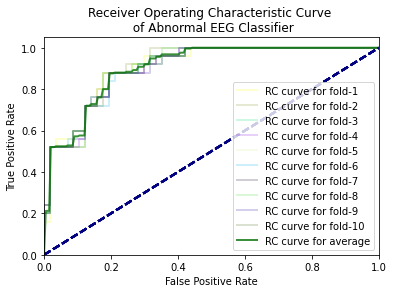

In [24]:
plt.figure()
for ind, color in enumerate(colors):
    lw = 2
    plt.plot(fpr_folds[ind], tpr_folds[ind], color=colors[ind],
             lw=lw, label=f'RC curve for {fold_names[ind]}', alpha=alphas[ind])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve \n of Abnormal EEG Classifier')
    plt.legend(loc="lower right")
plt.show()

## 4.3 Plot Boxplots and Scatter Plots of Testing Data

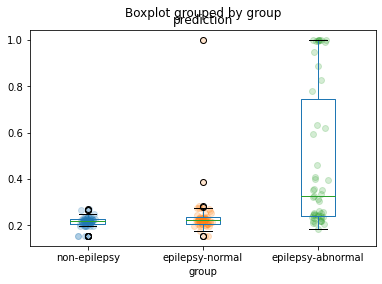

In [23]:
test_predictions = []
test_groups = []
y_pred_probs, test_inds = cv_scores['validate_ypred_prob'], cv_scores['test_inds']
for idx, (predictions, t_inds) in enumerate(zip(y_pred_probs, test_inds)):
    test_predictions_ = np.array(predictions)[t_inds]
    test_predictions.extend(test_predictions_)
    test_groups_ = groups[t_inds]
    test_groups.extend(test_groups_)

test_df = pd.DataFrame()
test_df['prediction'] = test_predictions
test_df['group'] = test_groups

group_names = list(include_subject_groups.keys())
xticks = [i+1 for i, g in enumerate(group_names)]

fig, ax = plt.subplots()
bp = test_df.boxplot(column='prediction', by='group', grid=False, ax=ax)
for gdx, g in enumerate(group_names):
    prediction_group = [pr for idx, pr in enumerate(test_predictions) if test_groups[idx] == gdx]
    x = np.random.normal(gdx+1, 0.04, size=len(prediction_group))
    plt.scatter(x, prediction_group, alpha=0.2, label=g)

ax.set_xticks(xticks)
ax.set_xticklabels(group_names)

    
plt.show()
